# Importing the required modules

In [1]:
# Module used for handling the file system.
import os

# Modules used for data handling and linear algebra.
import numpy as np
import pandas as pd

# Modules used for python utilities
from collections import Counter
import random as r

# Modules used for data visualisation.
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
sns.set_style("whitegrid")

# Utility Functions

## Random Colour Generator

In [2]:
def get_random_colours(n : int):
    all_colors = list(clr.CSS4_COLORS.keys())
    if len(all_colors) >= n:
        return r.sample(all_colors,n)
    else:
        return r.sample(all_colors,n//4)

# Structure of the dataset

In [3]:
class Metadata:
    
    def __init__(self, dataset_dir : str) -> None:
        self.PARENT = dataset_dir
        self.all_files = []
        self.CLASSES = ["Bulk","Video","Web","Interactive","Idle"]
        self.classwise_duration = [3599, 4496, 4203, 8934, 6341]
        self.file_sizes = []
        self.network_trace_count = None
        self.dtypes = None
    
    def __extract_class_from_filename(self, filename) -> str:
        return filename.split("_")[0]
    
    def __get_size_of_file(self,filename) -> int:
        abs_path = os.path.join(self.PARENT, filename)
        return os.path.getsize(abs_path)
    
    def class_distribution_network_traces(self) -> None:
        self.all_files = os.listdir(self.PARENT)
        self.file_sizes = list(map(self.__get_size_of_file,self.all_files))
        class_labels_foreach_file = list(map(self.__extract_class_from_filename, 
                                             self.all_files))
        self.network_trace_count = Counter(class_labels_foreach_file)
    
    def datatype_of_cols(self) -> None:
        sample_data = pd.read_csv(os.path.join(self.PARENT, 
                                               self.all_files[0]))
        self.dtypes = Counter([str(sample_data[i].dtype) for i in sample_data.columns])
    
    def summary(self) -> None:
        self.class_distribution_network_traces()
        self.datatype_of_cols()
        rows = 2
        columns = 2
        c = 0
        fig, axs = plt.subplots(rows, columns,figsize=(15,15))
        axs[0,0].bar(x = list(self.network_trace_count.keys()),
                     height = list(self.network_trace_count.values()),
                     color = get_random_colours(3),
                     edgecolor = "black")
        axs[0,0].set_title("Network Trace Classwise Count")
        axs[0,1].hist(self.file_sizes,
                      color = "crimson",
                      edgecolor = "black")
        axs[0,1].set_title("Network Trace File Sizes")
        axs[1,0].bar(x = self.CLASSES,
                     height = self.classwise_duration,
                     color = get_random_colours(3),
                     edgecolor = "black")
        axs[1,0].set_title("Classwise Duration of Data")
        axs[1,1].bar(x = list(self.dtypes.keys()),
                     height = list(self.dtypes.values()),
                     edgecolor = "black",
                     color = get_random_colours(3))
        axs[1,1].set_title("Types of Columns in the Dataset")
        fig.suptitle("Network Trace Dataset Insights")
        plt.subplots_adjust(bottom=0.5, top=0.93, hspace=0.5)
        plt.show()

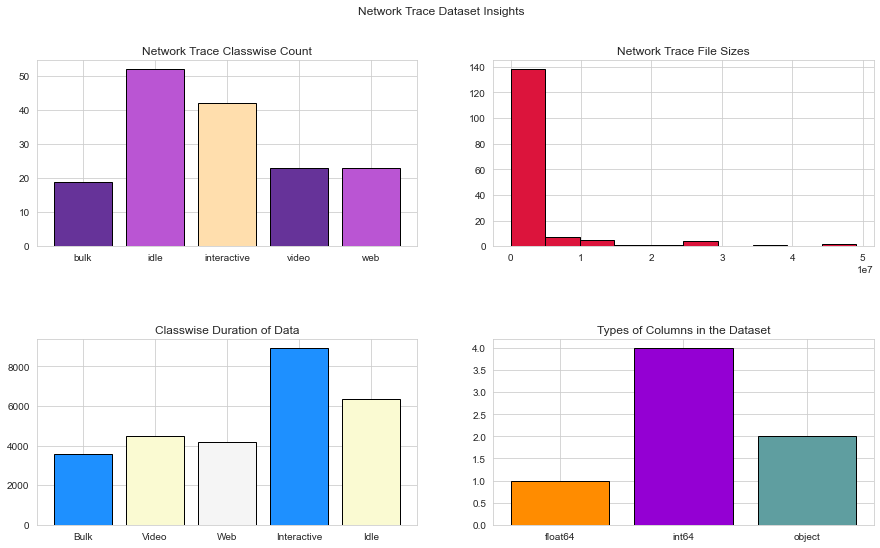

In [4]:
Metadata("../data/network-data").summary()

From the <i>subplot</i> we can make following inferences:
- There is <b>imbalance</b> in the dataset for classes with <b>idle traffic</b> having the <b>highest</b> network trace files while <b>bulk traffic</b> having the <b>lowest</b>. However, <b>bulk traffic</b> has the <b>highest</b> file size which might result in more network trace data for that class.
- The dataset has the <b>highest</b> amount of duration for <b>interactive traffic</b> followed by idle traffic.
- Lastly, the dataset is <b>dominated</b> with <b>integer</b> values which resemble <i>payload and port numbers for the source and destination</i> followed by <b>text</b> columns representing the <i>source and destination addresses</i>.

In [19]:
class DatasetEDA:
    
    def __init__(self, dataset_dir : str) -> None:
        self.PARENT = dataset_dir
        self.nt = None
        self.cnt = None
        self.numerical = {"discrete":[], "continuous":[]}
        self.categorical = []
        
    def combine_all_csvs(self):
        all_traces = [pd.read_csv(os.path.join(self.PARENT, file)) for file in os.listdir(self.PARENT)]
        self.nt = pd.concat(all_traces, ignore_index=True)
    
    def segreggate_columns(self):
        self.nt["data_len"] = self.nt["data_len"].astype("float64")
        for i in self.nt.columns:
            if self.nt[i].dtype == "int64":
                self.numerical["discrete"].append(i)
            elif self.nt[i].dtype == "float64":
                self.numerical["continuous"].append(i)
            else:
                self.categorical.append(i)
    
    def visualize_col_types(self):
        COL_TYPES = list(self.numerical.keys()) + ["Categorical"]
        cnt = list(map(len,self.numerical.values())) + [len(self.categorical)]
        
        plt.figure(figsize=(8,8))
        plt.bar(x=COL_TYPES,
                height=cnt,
                color=get_random_colours(3),
                edgecolor="black")
        plt.title("Type of features in the Network Traffic Dataset")
        plt.xlabel("Type of Feature")
        plt.ylabel("Count in dataset schema")
        plt.show()
    
    def categorical_feature_analysis(self):
        rows = 5
        columns = 1
        
        plt.rcParams['font.size'] = '12'
        
        fig, axs = plt.subplots(rows, columns,figsize=(25,25))
        all_cols = self.categorical + self.numerical["discrete"]
                                
        for i in range(len(all_cols)):
            self.cnt = dict(self.nt[all_cols[i]].value_counts().head(15))
            axs[i].bar(x=list(map(str, self.cnt.keys())),
                                  height=list(self.cnt.values()),
                                  color=get_random_colours(5),
                                  edgecolor='black')
            axs[i].set_title("Analysis of "+all_cols[i], fontsize=15)
            v = list(self.cnt.values())
            if len(v) == 15:
                if np.median(v) > 5000:
                    axs[i].set_ylim([0,np.mean(v)])
                else:
                    axs[i].set_ylim([0,10000])
            else:
                axs[i].set_ylim([0, 10000])
        
        fig.suptitle("Network Trace Dataset Categorical Feature Analysis", fontsize=20)
        plt.subplots_adjust(bottom=0.5, top=0.93, hspace=0.5)
        plt.show()
    
    def numerical_feature_analysis(self):
        self.nt["data_len"].plot(kind="hist")

    def temporal_feature_analysis(self):
        self.nt["time"].plot()
    

In [20]:
e = DatasetEDA("../data/network-data")

In [21]:
e.combine_all_csvs()

In [22]:
e.nt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046670 entries, 0 to 7046669
Data columns (total 7 columns):
 #   Column    Dtype  
---  ------    -----  
 0   time      float64
 1   proto     int64  
 2   data_len  int64  
 3   ip_src    object 
 4   ip_dst    object 
 5   src_port  int64  
 6   dst_port  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 376.3+ MB


In [23]:
e.segreggate_columns()

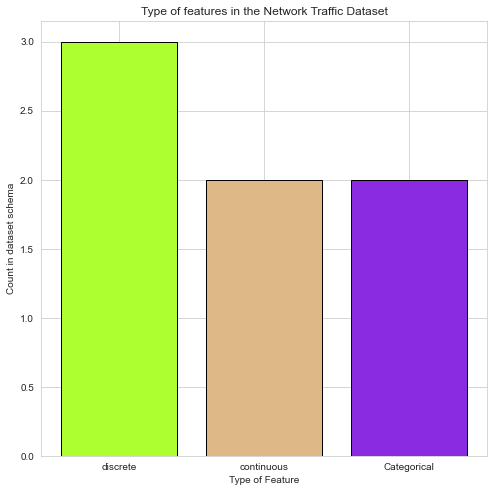

In [9]:
e.visualize_col_types()

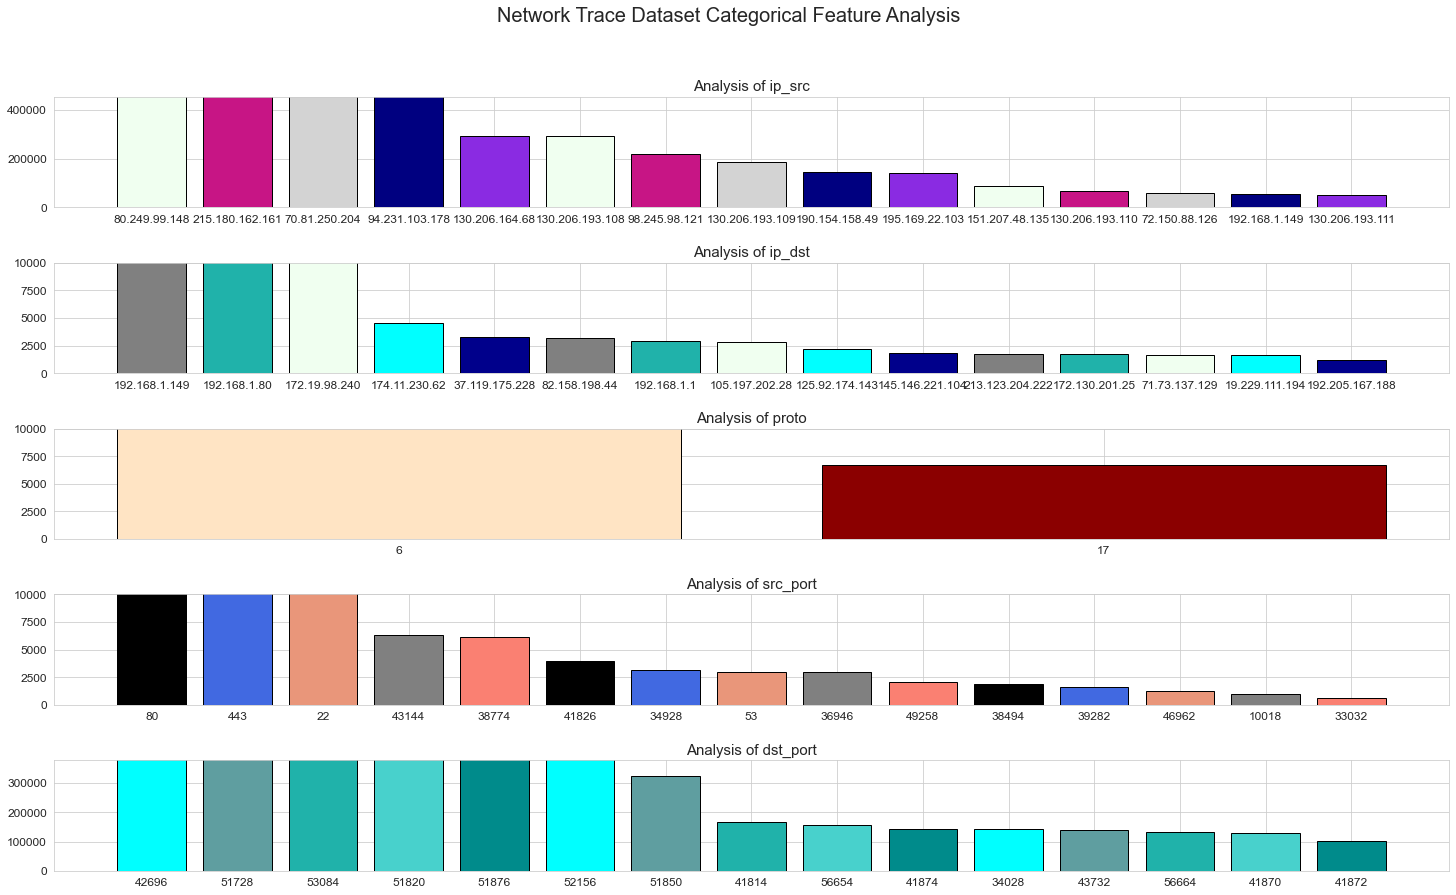

In [373]:
e.categorical_feature_analysis()

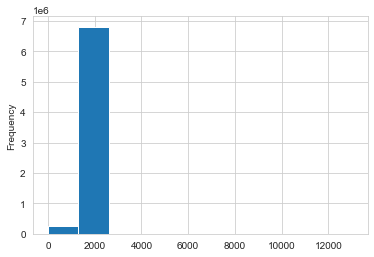

In [10]:
e.numerical_feature_analysis()

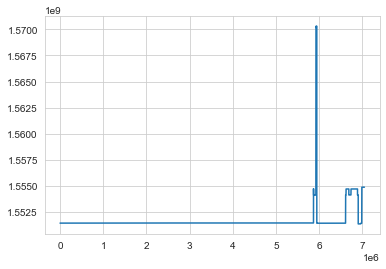

In [18]:
e.temporal_feature_analysis()